### Quick Intro
- Imbalanced classes are a common problem in machine learning classification. 
- It occurs when a disproportionate ratio of observation in each class.

In [1]:
# Import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import model

### Preapre Data

In [2]:
# Load the Credit Card Fraud Detection Dataset (available on Kaggle)
df = pd.read_csv('creditcard.csv')

# Print the shape
print(df.shape)

# Take a peek at the df
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Notes from Kaggle**
- The datasets contains transactions made by credit cards in September 2013 by European cardholders.
- Feature 'Time' is defined as the number of seconds elapsed between this transaction and the first transaction in the datasets.
- Features 1-V28 are results of PCA dimentionality reduction to protect user identities and sensitive. information. 
- Feature 'Amount' is the transaction amount, which can be used for example-dependent cost-sensitive learning. 
- Feature 'Class' is the responsible variable and it takes value 1 in case of fraud and 0 otherwise. 

In [3]:
# Compute the relative frequency based on 'Class'
df.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

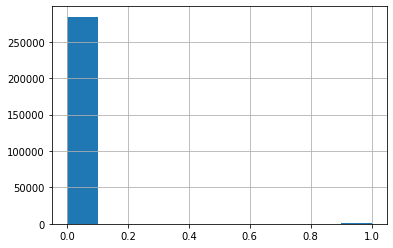

In [4]:
# Visualize the distribution of transaction based on 'Class'

df.Class.hist()
plt.show()

**Takeaways**
- The data is **highly imbalanced**, with only 0.17% of transactions being classfied as fraudulent. 
- Most machine learning algorithms work best when the number of samples in each class are about equal, because most of them are designed to maximize accuracy and reduce error. 

**The goal is to correctly classify the minority class of fraudulent transactioins.**

In [5]:
# Separate input features and target

y = df.Class
X = df.drop(columns='Class')

# Print the shapes
X.shape, y.shape

((284807, 30), (284807,))

In [6]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=27)

### Set Up Baseline

In [21]:
# Create evaluation dataframe

eval_df = pd.DataFrame(columns = ['model_type', 'data_type', 'accuracy', 'precision', 'recall'])
eval_df

,model_type,data_type,accuracy,precision,recall


In [10]:
# Use DummyClassifier object to predict the most frequent
dummy = DummyClassifier(strategy='most_frequent')

# Fit on train
dummy.fit(X_train, y_train)

# Predict on test
dummy_pred = dummy.predict(X_test)

# Compute accuracy
accuracy_score(y_test, dummy_pred)

0.9981461194910255

In [11]:
# Check the unique labels: should be 0
np.unique(dummy_pred)

array([0])

In [14]:
# Print the confusion matrix
confusion_matrix(y_test, dummy_pred)

array([[71070,     0],
       [  132,     0]])

In [22]:
# Evalute 

d = model.estimator_report('baseline', 'test', y_test, dummy_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,data_type,accuracy,precision,recall
0,baseline,test,0.998146,NaN,0.0


### Model by LogisticRegression

In [15]:
# Create a lr object
lr = LogisticRegression(solver='liblinear')

# Fit on train
lr.fit(X_train, y_train)

# Predict on test
lr_pred = lr.predict(X_test)

# Compute accuracy
accuracy_score(y_test, lr_pred)

0.9991994606893064

In [16]:
# Print the confusion matrix
confusion_matrix(y_test, lr_pred)

array([[71061,     9],
       [   48,    84]])

In [23]:
# Evaluate the lr model
d = model.estimator_report('LogisticRegression', 'test', y_test, lr_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,data_type,accuracy,precision,recall
0,baseline,test,0.998146,NaN,0.000000
1,LogisticRegression,test,0.999199,0.903226,0.636364


**Takeaways**
- Accuracy is not the best metric when evaluating imbalanced datasets.
- Other metrics like confusion matrix, precision, recall, and f1-score can provide better insight. 
- Recall:
    - f1-score: the weighted average of precision and recall.
    - precision: the number of true positives divided by the predicted postives.
    - recall: the number of true postives divided by the actual positives. 

### Oversample Minority Class
- Oversampling defined as adding more copies of the minority class.
- It can be a good choice when don't have a ton of data to work with. 

**Always split the data before trying oversampling.**

In [24]:
# Concat trainiing data back together
train = pd.concat([X_train, y_train], axis=1)

# Seperate minority and majority classes

no_fraud = train[train.Class == 0]
fraud = train[train.Class == 1]

# Upsample minority

fraud_upsampled = resample(fraud, 
                           replace=True, # sample with replacement
                           n_samples=len(no_fraud), # math number in majority class
                           random_state=27)

# Print the shape of the upsampled
fraud_upsampled.shape

(213245, 31)

In [25]:
# Combine majority and upsampled minority

upsampled = pd.concat([no_fraud, fraud_upsampled])

# Check the new class counts
upsampled.Class.value_counts() # Now an equal ratio of observation for each class

1    213245
0    213245
Name: Class, dtype: int64

**Model on upsampled train**

In [26]:
# Separete the features and target

y_train = upsampled.Class
X_train = upsampled.drop(columns='Class')

# Create a lr object
lr_upsampled = LogisticRegression(solver='liblinear')

# Fit on upsampled train
lr_upsampled.fit(X_train, y_train)

# Predict on test
lr_upsampled_pred = lr_upsampled.predict(X_test)

# Compute accuracy
accuracy_score(y_test, lr_upsampled_pred)

0.9807589674447347

In [27]:
# Print the confusion matrix
confusion_matrix(y_test, lr_upsampled_pred)

array([[69717,  1353],
       [   17,   115]])

In [28]:
# Evaluate the lr model
d = model.estimator_report('lr on the upsampled', 'test', y_test, lr_upsampled_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,data_type,accuracy,precision,recall
0,baseline,test,0.998146,NaN,0.000000
1,LogisticRegression,test,0.999199,0.903226,0.636364
2,lr on the upsampled,test,0.980759,0.078338,0.871212


**Takeaways**
- The recall increases to 87% while the precision drop significantly. 

### Undersample Majority Class
- Undersampling can be defined as removing some observations of the majority class. 
- It can be a good choice when you have a ton of data.
- A drawback is that valueable information may be lost, which could lead to underfitting and poor generalization to the test set. 

**Always split the data before trying oversampling.**

In [30]:
# Downsample majority

no_fraud_downsampled = resample(no_fraud, 
                                replace=False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state=27)

# Combine minority and downsampled majority
downsampled = pd.concat([no_fraud_downsampled, fraud])

# Check the counts
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [31]:
# Separete the features and train

y_train = downsampled.Class
X_train = downsampled.drop(columns='Class')

# Create LR object
lr_downsampled = LogisticRegression(solver='liblinear')

# Fit on downsampled data
lr_downsampled.fit(X_train, y_train)

# Predict on test
downsampled_pred = lr_downsampled.predict(X_test)

# Print the accuracy
accuracy_score(y_test, downsampled_pred)

0.9758574197354007

In [32]:
# Print the confusion matrix
confusion_matrix(y_test, downsampled_pred)

array([[69369,  1701],
       [   18,   114]])

In [33]:
# Evaluate the lr model
d = model.estimator_report('lr on the downsampled', 'test', y_test, downsampled_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,data_type,accuracy,precision,recall
0,baseline,test,0.998146,NaN,0.000000
1,LogisticRegression,test,0.999199,0.903226,0.636364
2,lr on the upsampled,test,0.980759,0.078338,0.871212
3,lr on the downsampled,test,0.975857,0.062810,0.863636


**Takeaways**
- Similar to upsampling, the recall increases to 86% while the precision drop significantly. 

### Generate Synthetic Samples
- SMOTE = Synthetic Minority Oversampling Technique
- SMOTE uses a nearest neighbors algorithm to generate new and synthetic data which could be used for training the model. 

In [46]:
# Separate input features and target

y = df.Class
X = df.drop(columns='Class')

# Print the shapes
X.shape, y.shape

((284807, 30), (284807,))

In [47]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=27)

In [48]:
# Create a SMOTE object
sm = SMOTE(random_state=27, sampling_strategy='auto')

In [49]:
# Check the class counts
y_train.value_counts() # Very imbalanced

0    213245
1       360
Name: Class, dtype: int64

In [50]:
# Fit sm on train
X_train, y_train = sm.fit_sample(X_train, y_train)

# Print the shapes
X_train.shape, y_train.shape

((426490, 30), (426490,))

In [51]:
# Check the class counts
y_train.value_counts() # Balanced

1    213245
0    213245
Name: Class, dtype: int64

In [52]:
# Create the lr for smote and fit on train
lr_sm = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# Predict on test
sm_pred = lr_sm.predict(X_test)

# Print the accuracy 
accuracy_score(y_test, sm_pred)

0.9858571388444145

In [53]:
# Print the confusion matrix
confusion_matrix(y_test, sm_pred)

array([[70081,   989],
       [   18,   114]])

In [55]:
# Evaluate the lr on SMOTE
# Evaluate the lr model

d = model.estimator_report('lr on the SMOTE', 'test', y_test, sm_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,data_type,accuracy,precision,recall
0,baseline,test,0.998146,NaN,0.000000
1,LogisticRegression,test,0.999199,0.903226,0.636364
2,lr on the upsampled,test,0.980759,0.078338,0.871212
3,lr on the downsampled,test,0.975857,0.062810,0.863636
4,lr on the SMOTE,test,0.985857,0.103354,0.863636


**Takeaways**
- Simiar to the up/down sampling, the recall is improved to 86% but precision significantly droped. 
- Overall, SMOTE performs the best among the three reampling techniques. 
- The idea behind the resampling techniques are to re-banlance between accuracy, precision and recall.